from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# **Analysis of SCR and brain response for shock**

In [1]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)



In [2]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
SCR_betapath = join(eCON,'SCR_new/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/{subj}_bucket_REML_clean.1D')
roi_betapath = join(eCON,'dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_{roi}/noProx/{subj}_bucket_REML.1D')
yoked = pd.read_excel(join(eCON,'SCR_new/scripts/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

In [3]:
rois = 'rvAI rdAI lvAI ldAI rPI lPI rBNST lBNST ACC\
        Amygdala_BLBM_La_R Amygdala_CeME_R Amygdala_BLBM_La_L Amygdala_CeME_L\
        rCa lCa rPa lPa rVS lVS vmPFC PCC1 PCC2 rPAG1 lPAG1'.split()

In [4]:
count = 0
df = pd.DataFrame()
for i, row in yoked.iterrows():
    for kind in ['control','uncontrol']:
        #print(row[kind])
        
        scr_beta = np.loadtxt(SCR_betapath.format(subj=row[kind],group=kind))[1::2][-1]
        roi_beta = np.vstack([np.loadtxt(roi_betapath.format(subj=row[kind],roi=roi,group=kind))[1::2][-1] for roi in rois]).T
        all_betas = np.append(scr_beta,roi_beta)

        tmp_df = pd.DataFrame(all_betas, index=['SCR']+rois).T
        tmp_df['SubjID'] = row[kind]
        tmp_df['Group'] = kind
        tmp_df['Pair'] = 'P{:02d}'.format(i)
        df = pd.concat([df,tmp_df],axis =0)

In [5]:
df.columns

Index(['SCR', 'rvAI', 'rdAI', 'lvAI', 'ldAI', 'rPI', 'lPI', 'rBNST', 'lBNST',
       'ACC', 'Amygdala_BLBM_La_R', 'Amygdala_CeME_R', 'Amygdala_BLBM_La_L',
       'Amygdala_CeME_L', 'rCa', 'lCa', 'rPa', 'lPa', 'rVS', 'lVS', 'vmPFC',
       'PCC1', 'PCC2', 'rPAG1', 'lPAG1', 'SubjID', 'Group', 'Pair'],
      dtype='object')

In [6]:
df_rBNST = df[['Pair','Group','SubjID','rBNST','SCR']]
df_rBNST.reset_index(drop=True,inplace=True)

In [7]:
df_rBNST_pairs = df[['Pair','rBNST','SCR']].groupby(['Pair'],as_index=True).diff()
df_rBNST_pairs.dropna(axis=0,how='all',inplace=True)
df_rBNST_pairs.index = pd.Series(df_rBNST.Pair.unique(),name='Pair')
df_rBNST_pairs.head()

,rBNST,SCR
Pair,,
P00,0.554184,-2.574000
P01,-0.673879,1.632302
P02,-0.640979,0.914620
P03,0.163446,1.775880
P04,0.189221,-0.039070


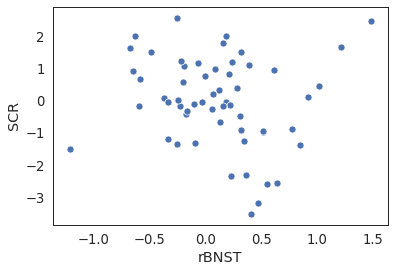

In [8]:
sns.scatterplot(x='rBNST',y='SCR',data=df_rBNST_pairs,s=50)

Text(0, 0.5, 'Right BST: (uncontrol - control)')

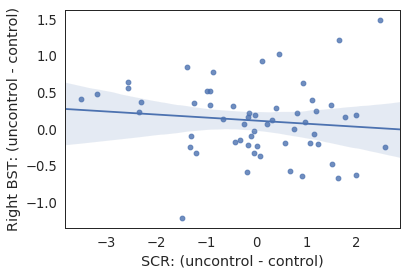

In [35]:
sns.regplot(y='rBNST',x='SCR',data=df_rBNST_pairs)
plt.xlabel('SCR: (uncontrol - control)')
plt.ylabel('Right BST: (uncontrol - control)')

In [10]:
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))

In [11]:
new_score_df = pd.DataFrame()
for i,row in yoked.iterrows():
    conTrait = scores[scores['SubID'] == row['control']]['TRAIT'].values[0]
    unconTrait = scores[scores['SubID'] == row['uncontrol']]['TRAIT'].values[0]
    
    conState = scores[scores['SubID'] == row['control']]['STATE'].values[0]
    unconState = scores[scores['SubID'] == row['uncontrol']]['STATE'].values[0]
    
    tmp_df = pd.DataFrame(['P{:02d}'.format(i),row['uncontrol'],row['control'],
                           unconTrait,conTrait,unconTrait-conTrait,np.mean([unconTrait,conTrait]),
                           unconState,conState,unconState-conState,np.mean([unconState,conState])],
                          index=['Pair',('SubID','uncontrol'),('SubID','control'),
                                  ('TRAIT','uncontrol'),('TRAIT','control'),('TRAIT','uncon-con'),('TRAIT','mean'),
                                  ('STATE','uncontrol'),('STATE','control'),('STATE','uncon-con'),('STATE','mean')]).T
    
    new_score_df = pd.concat([new_score_df,tmp_df],axis=0)
    
new_score_df.set_index('Pair',inplace=True)


new_score_df.columns = pd.MultiIndex.from_tuples(new_score_df.columns)

/home/climbach/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [12]:
new_score_df.head()

SubID             TRAIT                             STATE          \
     uncontrol control uncontrol control uncon-con  mean uncontrol control   
Pair                                                                         
P00     CON031  CON001        27      27         0    27        22      24   
P01     CON021  CON002        36      27         9  31.5        30      26   
P02     CON022  CON003        37      36         1  36.5        29      26   
P03     CON030  CON004        24      21         3  22.5        20      21   
P04     CON023  CON005        33      33         0    33        32      26   

                      
     uncon-con  mean  
Pair                  
P00         -2    23  
P01          4    28  
P02          3  27.5  
P03         -1  20.5  
P04          6    29

In [19]:
new_score_df.tail()

SubID             TRAIT                             STATE          \
     uncontrol control uncontrol control uncon-con  mean uncontrol control   
Pair                                                                         
P55     CON119  CON107        38      37         1  37.5        30      24   
P56     CON118  CON108        40      37         3  38.5        47      23   
P57     CON116  CON109        27      24         3  25.5        32      28   
P58     CON114  CON111        24      28        -4    26        23      20   
P59     CON113  CON112        40      34         6    37        34      30   

                      
     uncon-con  mean  
Pair                  
P55          6    27  
P56         24    35  
P57          4    30  
P58          3  21.5  
P59          4    32

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scores_norm = pd.DataFrame(ss.fit_transform(new_score_df[[('STATE', 'mean'),('STATE','uncon-con'),('TRAIT', 'mean'),('TRAIT','uncon-con')]]),
                          columns=['STATEmean','STATEdiff','TRAITmean','TRAITdiff'],index=new_score_df.index)


In [20]:
scores_norm.head()

,STATEmean,STATEdiff,TRAITmean,TRAITdiff
Pair,,,,
P00,-1.213278,-0.144191,-0.988402,-0.055850
P01,-0.419284,0.496243,-0.407588,3.127601
P02,-0.498684,0.389504,0.237760,0.297867
P03,-1.610275,-0.037452,-1.569215,1.005300
P04,-0.260486,0.709720,-0.213984,-0.055850


In [30]:
final_df = df_rBNST_pairs.join(scores_norm)
final_df.reset_index(drop=False,inplace=True)
print(final_df.head())
final_df.rename(columns={'rBNST':'y','Pair':'Subj'},inplace=True)
print(final_df.head())

  Pair     rBNST       SCR  STATEmean  STATEdiff  TRAITmean  TRAITdiff
0  P00  0.554184 -2.574000  -1.213278  -0.144191  -0.988402  -0.055850
1  P01 -0.673879  1.632302  -0.419284   0.496243  -0.407588   3.127601
2  P02 -0.640979  0.914620  -0.498684   0.389504   0.237760   0.297867
3  P03  0.163446  1.775880  -1.610275  -0.037452  -1.569215   1.005300
4  P04  0.189221 -0.039070  -0.260486   0.709720  -0.213984  -0.055850
  Subj         y       SCR  STATEmean  STATEdiff  TRAITmean  TRAITdiff
0  P00  0.554184 -2.574000  -1.213278  -0.144191  -0.988402  -0.055850
1  P01 -0.673879  1.632302  -0.419284   0.496243  -0.407588   3.127601
2  P02 -0.640979  0.914620  -0.498684   0.389504   0.237760   0.297867
3  P03  0.163446  1.775880  -1.610275  -0.037452  -1.569215   1.005300
4  P04  0.189221 -0.039070  -0.260486   0.709720  -0.213984  -0.055850


In [34]:
final_df.to_csv('data/uncon_v_con_rBNST_SCR_with_covariates.txt',sep='\t',index=False,float_format='%.4f')